In [40]:
%matplotlib notebook

import requests
import json
import pandas as pd
import numpy as np
import gmaps
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress
from collections import Counter
#from api_keys import g_key
g_key = "APIKEYHERE"

### GET DATA FROM pulldata FILE OUTPUT

In [41]:
#get csv files
#study data files
multi_city = "multi_restaurant_data.csv"

#set data to data frame
multi_df = pd.read_csv(multi_city)

In [42]:
#Run this code to set dataframe by defined city otherwise skip this cell
print ("Enter a city to be analyzed or enter <ALL> to get all cities")
getcity = input ("Input: ")
if getcity != "ALL":
    multi_df = multi_df.loc[multi_df["City"].str.contains(getcity, case = False)]
    print (f"Getting restaurant details in {getcity}")
    
else:
    print ("Getting restaurant details in all of the cities in csv file.....")
    print ("Done")
multi_df

Enter a city to be analyzed or enter <ALL> to get all cities
Input: Sydney
Getting restaurant details in Sydney


,Restaurant ID,Name,Cuisine,Locality,City,Rating,Total Number Ratings,Delivery,Latitude,Longitude
200,18241437,KOI Dessert Bar,"Desserts, Modern Australian","Kensington Street, Chippendale",Sydney,4.7,451,No,-33.885540,151.201767
201,18347530,Kobe Wagyu Yakiniku,"Japanese BBQ, BBQ, Healthy Food, Japanese, Sea...",CBD,Sydney,4.5,633,No,-33.877733,151.205456
202,16564875,The Grounds of Alexandria Cafe,"Coffee and Tea, Salad, Poké, Cafe Food","The Grounds of Alexandria, Alexandria",Sydney,4.4,1242,No,-33.911067,151.194125
203,16564139,Café Cre Asion,"Desserts, Cafe Food, Coffee and Tea",CBD,Sydney,4.8,415,No,-33.877972,151.210655
204,16566986,Devon,"Coffee and Tea, Cafe Food",Surry Hills,Sydney,4.5,583,No,-33.886173,151.207685
...,...,...,...,...,...,...,...,...,...,...
295,18518832,The Grounds of the City,"Cafe Food, Coffee and Tea",CBD,Sydney,4.2,243,No,-33.872159,151.207034
296,16558672,Pancakes On The Rocks,"Grill, Desserts, Pizza, Cafe Food, Coffee and Tea",The Rocks,Sydney,4.1,324,No,-33.858658,151.208448
297,17744545,Gogyo,"Japanese, Ramen",Surry Hills,Sydney,4.5,120,No,-33.882360,151.210141
298,16559582,Spice Temple,"Chinese, Fusion, Yum Cha",CBD,Sydney,4.3,244,No,-33.866122,151.210003


In [44]:
#This Section shows the top 10 Highest Rated Restaurant in the Data Frame
#Sorted by Rating then Total Number of Ratings
#multi_df.head()
multi_df.sort_values(by=["Rating","Total Number Ratings"] ,inplace=True, ascending = False)
multi_df.dropna(inplace=True)
multi_df.head(10)

,Restaurant ID,Name,Cuisine,Locality,City,Rating,Total Number Ratings,Delivery,Latitude,Longitude
215,16558798,Quay,Modern Australian,Circular Quay,Sydney,4.9,452,No,-33.858029,151.209970
233,16562433,Cow & The Moon,"Ice Cream, Desserts, Coffee and Tea",Enmore,Sydney,4.9,356,No,-33.899000,151.172029
230,16559171,Tetsuya's,Japanese,CBD,Sydney,4.9,330,No,-33.875136,151.204968
214,15547004,Restaurant Hubert,"French, European",CBD,Sydney,4.9,231,No,-33.865381,151.210490
272,16568476,La Mamma del Gelato Anita,Ice Cream,"Central Park, Chippendale",Sydney,4.9,231,No,-33.885072,151.200472
228,16569454,LuMi Bar & Dining,"Italian, Japanese",Pyrmont,Sydney,4.9,197,No,-33.866905,151.197397
262,15545439,Manpuku - Chatswood,"Japanese, Ramen",Chatswood,Sydney,4.9,196,No,-33.794394,151.189557
250,16566535,Lorraine's Patisserie,"Desserts, Bakery","Ivy, CBD",Sydney,4.9,111,No,-33.866612,151.207703
205,16564570,Sokyo,Japanese,"The Star, Pyrmont",Sydney,4.8,573,No,-33.869555,151.195900
203,16564139,Café Cre Asion,"Desserts, Cafe Food, Coffee and Tea",CBD,Sydney,4.8,415,No,-33.877972,151.210655


In [45]:
#get all possible cuisine in dataframe and set them in a list
cuisine_list = []
#loop through rows
#get all cuisine types store them in temp list
for index, row in multi_df.iterrows():
    cuiser = row["Cuisine"]
    cuiser = cuiser.split(", ")
    for cuisine in cuiser:
        cuisine_list.append(cuisine)

In [48]:
#count the duplicated cuisine in the list
cuisine_count = dict(Counter(cuisine_list))
cuis_df = pd.DataFrame({"Cuisine Count":cuisine_count})
cuis_df.sort_values(by=['Cuisine Count'], inplace=True, ascending = False)
cuis_df = cuis_df.head(6)
print(cuis_df)
#drop the coffee and tea cause it's already included in cafe food
cuis_df = cuis_df.drop(cuis_df.index[1])

#get the Top 1 cuisine
top_cuis = cuis_df.head(1)
for topcuisine in top_cuis.index:
    top_cuis = topcuisine


                   Cuisine Count
Coffee and Tea                34
Cafe Food                     31
Japanese                      23
Modern Australian             16
Desserts                      11
Salad                          9


<IPython.core.display.Javascript object>


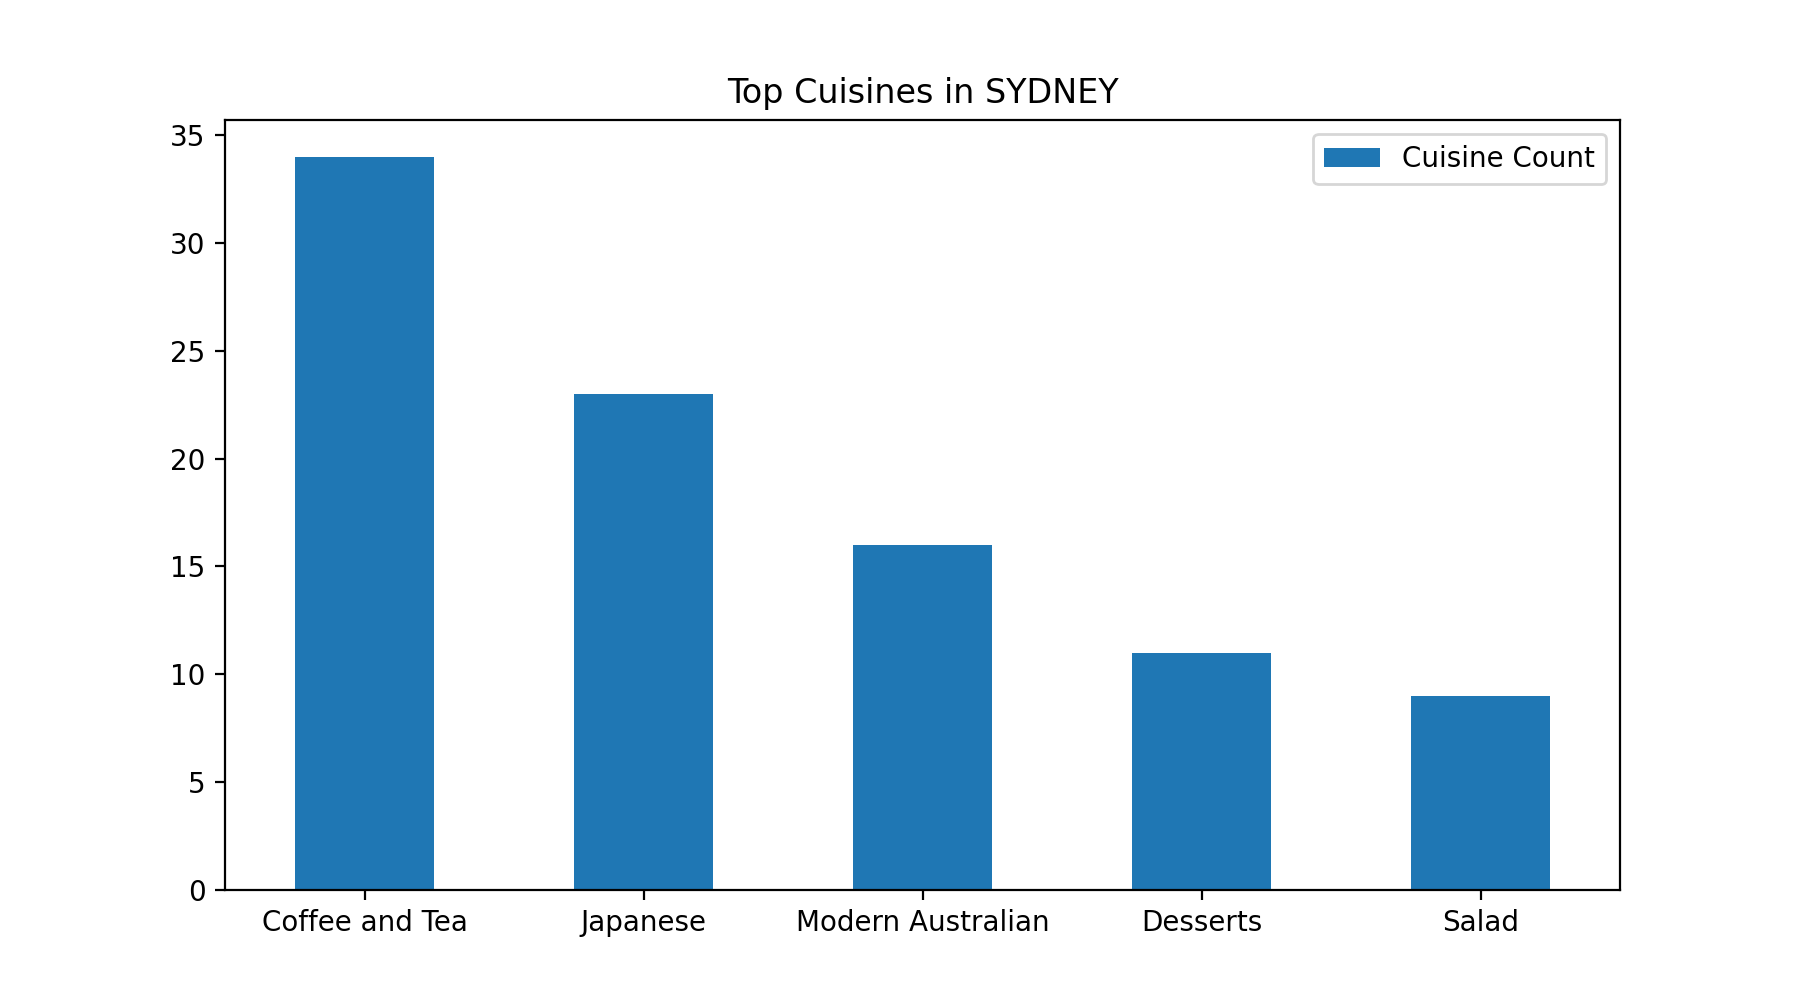

In [49]:
if getcity != "ALL":
    plot_title = getcity.upper()
else:
    plot_title = "Australia's Biggest Cities"

cuis_df.plot(kind = "bar",align="center",rot=360,subplots=True,figsize = (9,5))
plt.title(f"Top Cuisines in {plot_title}")
plt.savefig(f"Images/Top Cuisines in {plot_title}.png")


### TOP RATED CUISINE
*This Section the DataFrame will show all the restaurant that serves Cafe Food and Drop all restaurant that doesn't.

In [15]:
index_to_drop = []
#loop through all rows of dataset
for index, row in multi_df.iterrows():
    #split the cuisine cell
    cuiser = row["Cuisine"]
    cuiser = cuiser.split(", ")
    cf = False
    #check and get restaurants that serves cafe food then drop all restaurant that doesn't
    for cuisine in cuiser:
        if cuisine == top_cuis:
            cf = True
    if cf == False:
        index_to_drop.append(index)
new_multi_df = multi_df.drop(index_to_drop)
new_multi_df

,Restaurant ID,Name,Cuisine,Locality,City,Rating,Total Number Ratings,Delivery,Latitude,Longitude
102,16577212,Beatrix,"Coffee and Tea, Bakery",North Melbourne,Melbourne,4.9,384,No,-37.802367,144.944475
136,16578793,Patricia Coffee Brewers,Coffee and Tea,CBD,Melbourne,4.9,364,No,-37.814714,144.958260
124,16573759,Le Petit Gateau,"French, Desserts, Coffee and Tea",CBD,Melbourne,4.9,350,No,-37.816346,144.959632
106,18423923,Humble Rays,"Coffee and Tea, Cafe Food, Asian Fusion",Carlton,Melbourne,4.8,829,No,-37.804818,144.961554
140,18418602,Shanklin Cafe,"Modern Australian, Coffee and Tea, Cafe Food",Hawthorn,Melbourne,4.8,523,Yes,-37.833112,145.047330
154,16576959,La Belle Miette,"Desserts, French, Coffee and Tea",CBD,Melbourne,4.8,478,No,-37.814007,144.961446
183,16713830,Bibelot,"Desserts, Ice Cream, Cafe Food, Coffee and Tea",South Melbourne,Melbourne,4.8,427,No,-37.832569,144.958208
134,16574687,Journeyman,"Coffee and Tea, Cafe Food",Windsor,Melbourne,4.7,837,No,-37.852238,144.993247
158,17989264,Faraday's Cage,"Bakery, Coffee and Tea, Cafe Food",Fitzroy,Melbourne,4.7,380,No,-37.799376,144.982890
146,16586349,Little Rogue,Coffee and Tea,CBD,Melbourne,4.7,332,No,-37.811025,144.964052


In [16]:
if getcity == "ALL":
    city = input(f"Enter a city to get {top_cuis} Top 10 restaurant recommendations: ")
    recommendation_df = new_multi_df.loc[new_multi_df["City"].str.contains(city, case = False)]
    recommendation_df = recommendation_df.head(10)
else:
    recommendation_df = new_multi_df.loc[new_multi_df["City"].str.contains(getcity, case = False)]
    recommendation_df = recommendation_df.head(10)
recommendation_df

,Restaurant ID,Name,Cuisine,Locality,City,Rating,Total Number Ratings,Delivery,Latitude,Longitude
102,16577212,Beatrix,"Coffee and Tea, Bakery",North Melbourne,Melbourne,4.9,384,No,-37.802367,144.944475
136,16578793,Patricia Coffee Brewers,Coffee and Tea,CBD,Melbourne,4.9,364,No,-37.814714,144.958260
124,16573759,Le Petit Gateau,"French, Desserts, Coffee and Tea",CBD,Melbourne,4.9,350,No,-37.816346,144.959632
106,18423923,Humble Rays,"Coffee and Tea, Cafe Food, Asian Fusion",Carlton,Melbourne,4.8,829,No,-37.804818,144.961554
140,18418602,Shanklin Cafe,"Modern Australian, Coffee and Tea, Cafe Food",Hawthorn,Melbourne,4.8,523,Yes,-37.833112,145.047330
154,16576959,La Belle Miette,"Desserts, French, Coffee and Tea",CBD,Melbourne,4.8,478,No,-37.814007,144.961446
183,16713830,Bibelot,"Desserts, Ice Cream, Cafe Food, Coffee and Tea",South Melbourne,Melbourne,4.8,427,No,-37.832569,144.958208
134,16574687,Journeyman,"Coffee and Tea, Cafe Food",Windsor,Melbourne,4.7,837,No,-37.852238,144.993247
158,17989264,Faraday's Cage,"Bakery, Coffee and Tea, Cafe Food",Fitzroy,Melbourne,4.7,380,No,-37.799376,144.982890
146,16586349,Little Rogue,Coffee and Tea,CBD,Melbourne,4.7,332,No,-37.811025,144.964052


In [17]:
# NOTE: Do not change any of the code in this cell

# Using the template add the hotel marks to the heatmap
info_box_template = """
<dl>
<dt>Name</dt><dd>{Name}</dd>
<dt>City</dt><dd>{City}</dd>
<dt>Rating</dt><dd>{Rating}</dd>

</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
restau_info = [info_box_template.format(**row) for index, row in recommendation_df.iterrows()]
locations = recommendation_df[["Latitude", "Longitude"]]

In [19]:
# Configure gmaps with API key
gmaps.configure(api_key=g_key)
fig = gmaps.figure()

markers = gmaps.marker_layer(locations, info_box_content = restau_info)

# Add the layer to the map
fig.add_layer(markers)

# Display Map
if getcity == "ALL":
    print(f"Recommended {top_cuis} Restaurants in {city}")
else:
    print(f"Recommended {top_cuis} Restaurants in {getcity}")
fig

Recommended Coffee and Tea Restaurants in Melbourne


Figure(layout=FigureLayout(height='420px'))